### DQN Docking Case

In [1]:
import sys

## !pip install -e ../gym_space_docking/

loc = os.popen('pip3 show gym_space_docking').readlines()[7].split()[1]


sys.path.append(loc)


import gym
import os
import gym_space_docking

In [2]:
# include Network
import tensorflow as tf
import numpy as np

### create enviroment pygame

In [3]:
env = gym.make('space_docking-v0')
#print(env)

pygame 2.1.0 (SDL 2.0.16, Python 3.9.6)
Hello from the pygame community. https://www.pygame.org/contribute.html
/home/meyd/Documents/GitHub/Denny-Meyer/IronHack_Final_Project/gym_space_docking/gym_space_docking/envs


In [4]:
env.reset()

In [5]:
print(env.action_space)
#print(env.observation_space)
#print(type(env.action_space))

Discrete(7)


In [6]:
map, reward, done, info = env.step(2)

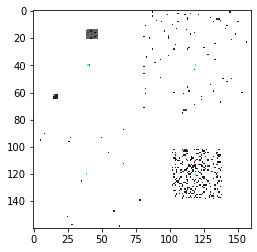

In [7]:
from matplotlib import pyplot as plt
plt.imshow(map, interpolation='nearest')
plt.show()

In [12]:
env.render()

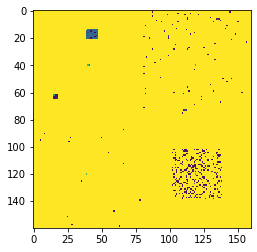

In [9]:
plt.imshow(preprocess_observations(map), interpolation='nearest')
plt.show()

In [10]:
# handle observations

# handle image scaling and resizing to fit the image in input data

def preprocess_observations(obs):
    # ToDo need love to work
    img = obs
    img = img.mean(axis=2)
    img = (img - 128) / 128 -1

    return img.reshape(160,160,1)
    pass

### create DQN network

In [11]:
# create network
input_height = 160
input_width = 160
input_channels = 1
conv_n_maps = [32,64,64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
conv_paddings = ['SAME'] * 3
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64 * 11 * 10 # 64 maps with size 11x10
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n# -> ToDo define in enviroment 
initializer =  tf.keras.initializers.VarianceScaling()# tf.contrib.layers.variance_scaling_initializer()

learning_rate = 0.01


In [12]:
tf.compat.v1.disable_eager_execution()

def q_network(X_state, name):
    prev_layer = X_state
    with tf.compat.v1.variable_scope(name) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(
            conv_n_maps, conv_kernel_sizes, conv_strides,
            conv_paddings, conv_activation):
            
            prev_layer = tf.compat.v1.layers.conv2d(
                prev_layer, filters=n_maps, kernel_size= kernel_size,
                strides= strides, padding=padding, activation=activation,
                kernel_initializer= initializer)
            
            last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
            
            hidden = tf.compat.v1.layers.dense(last_conv_layer_flat, n_hidden, 
                                                activation=hidden_activation,
                                                kernel_initializer=initializer)
            
            outputs = tf.compat.v1.layers.dense(hidden, n_outputs, 
                                                kernel_initializer=initializer)
        
        trainable_vars = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, 
                                                    scope=scope.name)
        
        trainable_vars_by_name = {var.name[len(scope.name):] : var for var in trainable_vars}

        return outputs, trainable_vars_by_name
            


In [13]:
X_state = tf.compat.v1.placeholder(tf.float32, shape=[None, input_height, input_width, input_channels])
online_q_values, online_vars = q_network(X_state=X_state, name='q_networks/online')
target_q_values, target_vars = q_network(X_state=X_state, name='q_networks/target')

copy_obs = [target_var.assign(online_vars[var_name]) for var_name, target_var in target_vars.items()]
copy_online_to_target = tf.group(*copy_obs)

/home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/convolutional.py:414: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  warnings.warn('`tf.layers.conv2d` is deprecated and '
/home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '


In [14]:
X_action = tf.compat.v1.placeholder(tf.int32, shape=[None])
q_value = tf.reduce_sum(target_q_values * tf.one_hot(X_action, n_outputs), axis=1, keepdims=True)

In [15]:
y = tf.compat.v1.placeholder(tf.float32, shape=[None, 1])
error = tf.abs(y - q_value)
clipped_error = tf.clip_by_value(error, 0.0, 1.0)
linear_error = 2*(error - clipped_error)
loss = tf.compat.v1.reduce_mean(tf.square(clipped_error) +linear_error)

In [16]:
global_step = tf.Variable(0, trainable=False, name='global_step')
optimizer = tf.compat.v1.train.MomentumOptimizer(learning_rate=learning_rate,name='momentum', momentum=0.9, use_nesterov=True)
training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

### tools

In [17]:
from collections import deque

replay_memory_size = 500000
replay_memory = deque([], maxlen=replay_memory_size)

def sample_memories(batch_size):
    indicies = np.random.permutation(len(replay_memory))[:batch_size]
    cols = [[], [], [], []] # state, action, rewards, next_state, continue
    for idx in indicies:
        memory = replay_memory[idx]
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return (cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1,1))

In [18]:
# actor explore enviroment

eps_min = 0.1
eps_max = 1.0
eps_decay_steps = 2000000

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        return np.argmax(q_values)


### run training

In [19]:
n_steps = 4000000
training_start = 10000
training_interval = 4
save_steps = 1000
copy_steps = 10000
discont_rate = 0.99
skip_start = 90
batch_size = 50
iteration = 0
checkpoint_path = './docking_dqn.ckpt'
done = True


In [20]:
with tf.compat.v1.Session() as sess:
    if os.path.isfile(checkpoint_path + '.index'):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_online_to_target.run()
    
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        if done:
            obs = env.reset()
            for skip in range(skip_start):
                obs, reward, done, info = env.step(0)
            state = preprocess_observations(obs)

        # online dqn evaluate
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greedy(q_values, step)

        # online dqn play
        obs, reward, done, info = env.step(action)
        next_state = preprocess_observations(obs)

        # remember what happend
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state

        if iteration < training_start or iteration % training_interval != 0:
            continue # only train after warmup period and at regular intervals

        # get probe from memory
        # use target dqn to get target q value
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (
            sample_memories(batch_size=batch_size))
        
        next_q_values = target_q_values.eval(
            feed_dict={X_state: X_state_val})

        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues * discont_rate * max_next_q_values

        # train online dqn
        training_op.run(feed_dict={X_state: X_state_val, X_action: X_action_val, y: y_val})

        # copy online dqn to target dqn
        if step % copy_steps == 0:
            copy_online_to_target.run()
        
        # save regulary
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

2021-12-10 22:34:35.102935: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-10 22:34:35.103189: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-10 22:34:35.103612: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2021-12-10 22:34:35.112294: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
2021-12-10 22:34:35.139725: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz


InvalidArgumentError: Input to reshape is a tensor with 25600 values, but the requested shape requires a multiple of 7040
	 [[node q_networks/online/Reshape_2 (defined at tmp/ipykernel_13938/1906098050.py:15) ]]

Errors may have originated from an input operation.
Input Source operations connected to node q_networks/online/Reshape_2:
 q_networks/online/conv2d_2/Relu (defined at tmp/ipykernel_13938/1906098050.py:10)

Original stack trace for 'q_networks/online/Reshape_2':
  File "home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
    self.io_loop.start()
  File "home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
    self._run_once()
  File "home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
    handle._run()
  File "home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
    await self.process_one()
  File "home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 446, in process_one
    await dispatch(*args)
  File "home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
    await result
  File "home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
    reply_content = await reply_content
  File "home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2901, in run_cell
    result = self._run_cell(
  File "home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2947, in _run_cell
    return runner(coro)
  File "home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3172, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3364, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "tmp/ipykernel_13938/2287348265.py", line 2, in <module>
    online_q_values, online_vars = q_network(X_state=X_state, name='q_networks/online')
  File "tmp/ipykernel_13938/1906098050.py", line 15, in q_network
    last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
  File "home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py", line 201, in wrapper
    return target(*args, **kwargs)
  File "home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py", line 195, in reshape
    result = gen_array_ops.reshape(tensor, shape, name)
  File "home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/tensorflow/python/ops/gen_array_ops.py", line 8377, in reshape
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py", line 748, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 3528, in _create_op_internal
    ret = Operation(
  File "home/meyd/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 1990, in __init__
    self._traceback = tf_stack.extract_stack()


##### cool, actally no big errors....time to work on the enviroment, passing the right values

In [4]:
!pip install --upgrade pip setuptools wheel
!pip install opencv-python
!pip install gym[atari]


     |████████████████████████████████| 1.7 MB 2.0 MB/s eta 0:00:01
  Using cached setuptools-59.5.0-py3-none-any.whl (952 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 58.0.4
    Uninstalling setuptools-58.0.4:
      Successfully uninstalled setuptools-58.0.4
  Attempting uninstall: pip
    Found existing installation: pip 21.2.4
    Uninstalling pip-21.2.4:
      Successfully uninstalled pip-21.2.4
     |████████████████████████████████| 60.3 MB 28 kB/s             


In [4]:

%matplotlib inline
import gym
from gym.wrappers import Monitor
import itertools
import numpy as np
import os
import random
import sys
import tensorflow as tf
from lib_ploting import ploting

from collections import deque, namedtuple
env = gym.make('Breakout-v0')

# Atari Actions: 0 (noop), 1 (fire), 2 (left) and 3 (right) are valid actions
#VALID_ACTIONS = [0, 1, 2, 3, 4,5 ,6 ]
# Atari Actions: 0 (noop), 1 (fire), 2 (left) and 3 (right) are valid actions
VALID_ACTIONS = [0, 1, 2, 3]


AttributeError: module 'gym.envs.atari' has no attribute 'AtariEnv'

In [2]:
print("Action space size: {}".format(env.action_space.n))
# print(env.get_action_meanings())
observation = env.reset()
print("Observation space shape: {}".format(observation.shape))
plt.figure()
plt.imshow(env.render(mode='rgb_array'))
[env.step(2) for x in range(1)]
plt.figure()
plt.imshow(env.render(mode='rgb_array'))
env.render(close=True)

NameError: name 'env' is not defined

In [ ]:
# Check out what a cropped image looks like
plt.imshow(observation[34:-16,:,:])

In [12]:
class StateProcessor():
    """
    Processes a raw Atari images. Resizes it and converts it to grayscale.
    """
    def __init__(self):
        # Build the Tensorflow graph
        with tf.variable_scope("state_processor"):
            self.input_state = tf.placeholder(shape=[210, 160, 3], dtype=tf.uint8)
            self.output = tf.image.rgb_to_grayscale(self.input_state)
            self.output = tf.image.crop_to_bounding_box(self.output, 34, 0, 160, 160)
            self.output = tf.image.resize_images(
                self.output, [84, 84], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
            self.output = tf.squeeze(self.output)
    def process(self, sess, state):
        """
        Args:
            sess: A Tensorflow session object
            state: A [210, 160, 3] Atari RGB State
        Returns:
            A processed [84, 84, 1] state representing grayscale values.
        """
        return sess.run(self.output, { self.input_state: state })

In [13]:
class Estimator():
    """Q-Value Estimator neural network.
    This network is used for both the Q-Network and the Target Network.
    """
    def __init__(self, scope="estimator", summaries_dir=None):
        self.scope = scope
        # Writes Tensorboard summaries to disk
        self.summary_writer = None
        with tf.variable_scope(scope):
            # Build the graph
            self._build_model()
            if summaries_dir:
                summary_dir = os.path.join(summaries_dir, "summaries_{}".format(scope))
                if not os.path.exists(summary_dir):
                    os.makedirs(summary_dir)
                self.summary_writer = tf.summary.FileWriter(summary_dir)
    def _build_model(self):
        """
        Builds the Tensorflow graph.
        """
        # Placeholders for our input
        # Our input are 4 RGB frames of shape 160, 160 each
        self.X_pl = tf.placeholder(shape=[None, 84, 84, 4], dtype=tf.uint8, name="X")
        # The TD target value
        self.y_pl = tf.placeholder(shape=[None], dtype=tf.float32, name="y")
        # Integer id of which action was selected
        self.actions_pl = tf.placeholder(shape=[None], dtype=tf.int32, name="actions")
        X = tf.to_float(self.X_pl) / 255.0
        batch_size = tf.shape(self.X_pl)[0]
        # Three convolutional layers
        conv1 = tf.contrib.layers.conv2d(
            X, 32, 8, 4, activation_fn=tf.nn.relu)
        conv2 = tf.contrib.layers.conv2d(
            conv1, 64, 4, 2, activation_fn=tf.nn.relu)
        conv3 = tf.contrib.layers.conv2d(
            conv2, 64, 3, 1, activation_fn=tf.nn.relu)
        # Fully connected layers
        flattened = tf.contrib.layers.flatten(conv3)
        fc1 = tf.contrib.layers.fully_connected(flattened, 512)
        self.predictions = tf.contrib.layers.fully_connected(fc1, len(VALID_ACTIONS))
        # Get the predictions for the chosen actions only
        gather_indices = tf.range(batch_size) * tf.shape(self.predictions)[1] + self.actions_pl
        self.action_predictions = tf.gather(tf.reshape(self.predictions, [-1]), gather_indices)
        # Calcualte the loss
        self.losses = tf.squared_difference(self.y_pl, self.action_predictions)
        self.loss = tf.reduce_mean(self.losses)
        # Optimizer Parameters from original paper
        self.optimizer = tf.train.RMSPropOptimizer(0.00025, 0.99, 0.0, 1e-6)
        self.train_op = self.optimizer.minimize(self.loss, global_step=tf.contrib.framework.get_global_step())
        # Summaries for Tensorboard
        self.summaries = tf.summary.merge([
            tf.summary.scalar("loss", self.loss),
            tf.summary.histogram("loss_hist", self.losses),
            tf.summary.histogram("q_values_hist", self.predictions),
            tf.summary.scalar("max_q_value", tf.reduce_max(self.predictions))
        ])
    def predict(self, sess, s):
        """
        Predicts action values.
        Args:
          sess: Tensorflow session
          s: State input of shape [batch_size, 4, 160, 160, 3]
        Returns:
          Tensor of shape [batch_size, NUM_VALID_ACTIONS] containing the estimated 
          action values.
        """
        return sess.run(self.predictions, { self.X_pl: s })
    def update(self, sess, s, a, y):
        """
        Updates the estimator towards the given targets.
        Args:
          sess: Tensorflow session object
          s: State input of shape [batch_size, 4, 160, 160, 3]
          a: Chosen actions of shape [batch_size]
          y: Targets of shape [batch_size]
        Returns:
          The calculated loss on the batch.
        """
        feed_dict = { self.X_pl: s, self.y_pl: y, self.actions_pl: a }
        summaries, global_step, _, loss = sess.run(
            [self.summaries, tf.contrib.framework.get_global_step(), self.train_op, self.loss],
            feed_dict)
        if self.summary_writer:
            self.summary_writer.add_summary(summaries, global_step)
        return loss

In [14]:
def copy_model_parameters(sess, estimator1, estimator2):
    """
    Copies the model parameters of one estimator to another.
    Args:
      sess: Tensorflow session instance
      estimator1: Estimator to copy the paramters from
      estimator2: Estimator to copy the parameters to
    """
    e1_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator1.scope)]
    e1_params = sorted(e1_params, key=lambda v: v.name)
    e2_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator2.scope)]
    e2_params = sorted(e2_params, key=lambda v: v.name)
    update_ops = []
    for e1_v, e2_v in zip(e1_params, e2_params):
        op = e2_v.assign(e1_v)
        update_ops.append(op)
    sess.run(update_ops)

In [15]:
def make_epsilon_greedy_policy(estimator, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    Args:
        estimator: An estimator that returns q values for a given state
        nA: Number of actions in the environment.
    Returns:
        A function that takes the (sess, observation, epsilon) as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    """
    def policy_fn(sess, observation, epsilon):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(sess, np.expand_dims(observation, 0))[0]
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [16]:
def deep_q_learning(sess,
                    env,
                    q_estimator,
                    target_estimator,
                    state_processor,
                    num_episodes,
                    experiment_dir,
                    replay_memory_size=500000,
                    replay_memory_init_size=50000,
                    update_target_estimator_every=10000,
                    discount_factor=0.99,
                    epsilon_start=1.0,
                    epsilon_end=0.1,
                    epsilon_decay_steps=500000,
                    batch_size=32,
                    record_video_every=50):
    """
    Q-Learning algorithm for fff-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    Args:
        sess: Tensorflow Session object
        env: OpenAI environment
        q_estimator: Estimator object used for the q values
        target_estimator: Estimator object used for the targets
        state_processor: A StateProcessor object
        num_episodes: Number of episodes to run for
        experiment_dir: Directory to save Tensorflow summaries in
        replay_memory_size: Size of the replay memory
        replay_memory_init_size: Number of random experiences to sampel when initializing 
          the reply memory.
        update_target_estimator_every: Copy parameters from the Q estimator to the 
          target estimator every N steps
        discount_factor: Lambda time discount factor
        epsilon_start: Chance to sample a random action when taking an action.
          Epsilon is decayed over time and this is the start value
        epsilon_end: The final minimum value of epsilon after decaying is done
        epsilon_decay_steps: Number of steps to decay epsilon over
        batch_size: Size of batches to sample from the replay memory
        record_video_every: Record a video every N episodes
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    # The replay memory
    replay_memory = []
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))
    # Create directories for checkpoints and summaries
    checkpoint_dir = os.path.join(experiment_dir, "checkpoints")
    checkpoint_path = os.path.join(checkpoint_dir, "model")
    monitor_path = os.path.join(experiment_dir, "monitor")
    
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    if not os.path.exists(monitor_path):
        os.makedirs(monitor_path)
    saver = tf.train.Saver()
    # Load a previous checkpoint if we find one
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
        print("Loading model checkpoint {}...\n".format(latest_checkpoint))
        saver.restore(sess, latest_checkpoint)
    
    # Get the current time step
    total_t = sess.run(tf.contrib.framework.get_global_step())
    # The epsilon decay schedule
    epsilons = np.linspace(epsilon_start, epsilon_end, epsilon_decay_steps)
    # The policy we're following
    policy = make_epsilon_greedy_policy(
        q_estimator,
        len(VALID_ACTIONS))
    # Populate the replay memory with initial experience
    print("Populating replay memory...")
    state = env.reset()
    state = state_processor.process(sess, state)
    state = np.stack([state] * 4, axis=2)
    for i in range(replay_memory_init_size):
        action_probs = policy(sess, state, epsilons[min(total_t, epsilon_decay_steps-1)])
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        next_state, reward, done, _ = env.step(VALID_ACTIONS[action])
        next_state = state_processor.process(sess, next_state)
        next_state = np.append(state[:,:,1:], np.expand_dims(next_state, 2), axis=2)
        replay_memory.append(Transition(state, action, reward, next_state, done))
        if done:
            state = env.reset()
            state = state_processor.process(sess, state)
            state = np.stack([state] * 4, axis=2)
        else:
            state = next_state
    # Record videos
    # Add env Monitor wrapper
    env = Monitor(env, directory=monitor_path, video_callable=lambda count: count % record_video_every == 0, resume=True)
    for i_episode in range(num_episodes):
        # Save the current checkpoint
        saver.save(tf.get_default_session(), checkpoint_path)
        # Reset the environment
        state = env.reset()
        state = state_processor.process(sess, state)
        state = np.stack([state] * 4, axis=2)
        loss = None
        # One step in the environment
        for t in itertools.count():
            # Epsilon for this time step
            epsilon = epsilons[min(total_t, epsilon_decay_steps-1)]
            # Add epsilon to Tensorboard
            episode_summary = tf.Summary()
            episode_summary.value.add(simple_value=epsilon, tag="epsilon")
            q_estimator.summary_writer.add_summary(episode_summary, total_t)
            # Maybe update the target estimator
            if total_t % update_target_estimator_every == 0:
                copy_model_parameters(sess, q_estimator, target_estimator)
                print("\nCopied model parameters to target network.")
            # Print out which step we're on, useful for debugging.
            print("\rStep {} ({}) @ Episode {}/{}, loss: {}".format(
                    t, total_t, i_episode + 1, num_episodes, loss), end="")
            sys.stdout.flush()
            # Take a step
            action_probs = policy(sess, state, epsilon)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(VALID_ACTIONS[action])
            next_state = state_processor.process(sess, next_state)
            next_state = np.append(state[:,:,1:], np.expand_dims(next_state, 2), axis=2)
            # If our replay memory is full, pop the first element
            if len(replay_memory) == replay_memory_size:
                replay_memory.pop(0)
            # Save transition to replay memory
            replay_memory.append(Transition(state, action, reward, next_state, done))   
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            # Sample a minibatch from the replay memory
            samples = random.sample(replay_memory, batch_size)
            states_batch, action_batch, reward_batch, next_states_batch, done_batch = map(np.array, zip(*samples))
            # Calculate q values and targets
            # This is where Double Q-Learning comes in!
            q_values_next = q_estimator.predict(sess, next_states_batch)
            best_actions = np.argmax(q_values_next, axis=1)
            q_values_next_target = target_estimator.predict(sess, next_states_batch)
            targets_batch = reward_batch + np.invert(done_batch).astype(np.float32) * discount_factor * q_values_next_target[np.arange(batch_size), best_actions]

            # Perform gradient descent update
            states_batch = np.array(states_batch)
            loss = q_estimator.update(sess, states_batch, action_batch, targets_batch)
            if done:
                break
            state = next_state
            total_t += 1
        # Add summaries to tensorboard
        episode_summary = tf.Summary()
        episode_summary.value.add(simple_value=stats.episode_rewards[i_episode], node_name="episode_reward", tag="episode_reward")
        episode_summary.value.add(simple_value=stats.episode_lengths[i_episode], node_name="episode_length", tag="episode_length")
        q_estimator.summary_writer.add_summary(episode_summary, total_t)
        q_estimator.summary_writer.flush()
        yield total_t, plotting.EpisodeStats(
            episode_lengths=stats.episode_lengths[:i_episode+1],
            episode_rewards=stats.episode_rewards[:i_episode+1])
    return stats

In [18]:
tf.compat.v1.reset_default_graph()
# Where we save our checkpoints and graphs
experiment_dir = os.path.abspath("./experiments/{}".format(env.spec.id))
# Create a glboal step variable
global_step = tf.Variable(0, name='global_step', trainable=False)
    
# Create estimators
q_estimator = Estimator(scope="q", summaries_dir=experiment_dir)
target_estimator = Estimator(scope="target_q")
# State processor
state_processor = StateProcessor()
# Run it!
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for t, stats in deep_q_learning(sess,
                                    env,
                                    q_estimator=q_estimator,
                                    target_estimator=target_estimator,
                                    state_processor=state_processor,
                                    experiment_dir=experiment_dir,
                                    num_episodes=10000,
                                    replay_memory_size=500000,
                                    replay_memory_init_size=50000,
                                    update_target_estimator_every=10000,
                                    epsilon_start=1.0,
                                    epsilon_end=0.1,
                                    epsilon_decay_steps=500000,
                                    discount_factor=0.99,
                                    batch_size=32):
        print("\nEpisode Reward: {}".format(stats.episode_rewards[-1]))


NameError: name 'env' is not defined